In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# Set a fixed seed for reproducibility
torch.manual_seed(66)

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}")


Device being used: cuda


In [3]:
def prepare_data(batch_size=128, image_size=64):
    
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])
    dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print("Data Preparation Complete")
    print(f"Number of training batches: {len(dataloader)}")
    return dataloader

# Prepare the data
dataloader = prepare_data()


Files already downloaded and verified
Data Preparation Complete
Number of training batches: 391


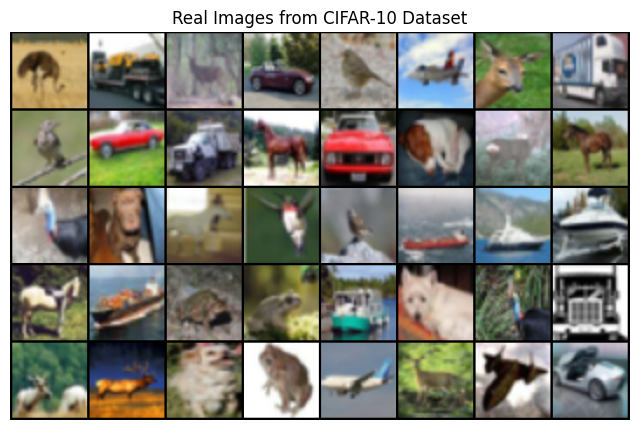

In [4]:
def display_real_images(dataloader, num_images=40):
    
    real_images, _ = next(iter(dataloader))  # Fetch one batch of real images
    real_images = real_images[:num_images] * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Plot real images in a grid
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Real Images from CIFAR-10 Dataset")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_images, padding=2, normalize=False), (1, 2, 0)))
    plt.show()

# Example Usage
display_real_images(dataloader)


In [7]:
class ACGANGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, num_classes):
        super(ACGANGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, nz)  # Match embedding size to noise size (nz)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + nz, ngf * 8, 4, 1, 0, bias=False),  # Updated input channels
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embeddings = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat([noise, label_embeddings], dim=1)
        return self.main(input)


In [8]:
class ACGANDiscriminator(nn.Module):
    def __init__(self, nc, ndf, num_classes):
        super(ACGANDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # Real/fake output
        self.adv_head = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)  
        # Class label prediction
        self.aux_head = nn.Conv2d(ndf * 8, num_classes, 4, 1, 0, bias=False)

    def forward(self, input):
        features = self.main(input)
        real_fake = self.adv_head(features).view(-1)  # Real/fake classification
        class_labels = self.aux_head(features).view(-1, 10)  # Class prediction
        return real_fake, class_labels


In [9]:
nz = 100  # Size of the noise vector
nc = 3    # Number of channels (CIFAR-10 images are RGB)
ngf = 64  # Generator feature size
ndf = 64  # Discriminator feature size
num_classes = 10  # Number of CIFAR-10 classes

netG = ACGANGenerator(nz, nc, ngf, num_classes).to(device)
netD = ACGANDiscriminator(nc, ndf, num_classes).to(device)

print("Generator Model:")
print(netG)

print("\nDiscriminator Model:")
print(netD)


Generator Model:
ACGANGenerator(
  (label_emb): Embedding(10, 100)
  (main): Sequential(
    (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2,

In [10]:
# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for real/fake classification
auxiliary_loss = nn.CrossEntropyLoss()     # Cross-Entropy Loss for class label prediction

# Optimizers
lr = 0.0002  # Learning rate
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizers

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))  # Optimizer for Generator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))  # Optimizer for Discriminator

print("Loss functions and optimizers initialized successfully.")


Loss functions and optimizers initialized successfully.


In [11]:
from torchmetrics.image.fid import FrechetInceptionDistance

def train_acgan_with_fid(netG, netD, dataloader, optimizerG, optimizerD, adversarial_loss, auxiliary_loss, nz, num_classes, device, num_epochs):
    """
    ACGAN Training Loop with FID calculation.

    Args:
    - netG: Generator model.
    - netD: Discriminator model.
    - dataloader: DataLoader for real images.
    - optimizerG: Optimizer for the generator.
    - optimizerD: Optimizer for the discriminator.
    - adversarial_loss: Loss function for real/fake classification.
    - auxiliary_loss: Loss function for class label prediction.
    - nz: Size of the latent noise vector.
    - num_classes: Number of image classes.
    - device: Device to use (CPU or GPU).
    - num_epochs: Number of training epochs.

    Returns:
    - G_losses: List of generator losses over the training period.
    - D_losses: List of discriminator losses over the training period.
    - FID_scores: List of FID scores calculated at each epoch.
    """
    G_losses, D_losses, FID_scores = [], [], []
    fid = FrechetInceptionDistance(feature=2048).to(device)  # Initialize FID metric

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        for i, (real_images, labels) in enumerate(dataloader):
            batch_size = real_images.size(0)

            # Move data to device
            real_images = real_images.to(device)
            labels = labels.to(device)
            valid = torch.ones(batch_size, device=device).view(-1)  # Reshape target tensor
            fake = torch.zeros(batch_size, device=device).view(-1)  # Reshape target tensor

            # ---------------------
            # Train Discriminator
            # ---------------------
            netD.zero_grad()

            # Real images
            real_validity, real_aux = netD(real_images)
            d_real_loss = adversarial_loss(real_validity, valid) + auxiliary_loss(real_aux, labels)

            # Fake images
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_images = netG(noise, fake_labels)
            fake_validity, fake_aux = netD(fake_images.detach())
            d_fake_loss = adversarial_loss(fake_validity, fake) + auxiliary_loss(fake_aux, fake_labels)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizerD.step()

            # -----------------
            # Train Generator
            # -----------------
            netG.zero_grad()

            # Generate fake images and calculate loss
            gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            gen_images = netG(noise, gen_labels)
            validity, pred_labels = netD(gen_images)
            g_loss = adversarial_loss(validity, valid) + auxiliary_loss(pred_labels, gen_labels)

            g_loss.backward()
            optimizerG.step()

            # Save losses for plotting
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())

        # FID Calculation
        fid.reset()  # Clear FID state

        # Add real images to FID metric
        for real_batch, _ in dataloader:
            real_batch = (real_batch * 0.5 + 0.5) * 255  # Denormalize to [0, 255]
            real_batch = real_batch.to(torch.uint8).to(device)  # Convert to uint8
            fid.update(real_batch, real=True)

        # Add fake images to FID metric
        with torch.no_grad():
            for _ in range(len(dataloader)):
                noise = torch.randn(batch_size, nz, 1, 1, device=device)
                fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)
                fake_batch = netG(noise, fake_labels)
                fake_batch = (fake_batch * 0.5 + 0.5) * 255  # Denormalize to [0, 255]
                fake_batch = fake_batch.to(torch.uint8).to(device)  # Convert to uint8
                fid.update(fake_batch, real=False)

        fid_score = fid.compute().item()
        FID_scores.append(fid_score)

        # Print progress every 10 epochs or at the first epoch
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Loss_D: {d_loss.item():.4f}, Loss_G: {g_loss.item():.4f}, FID: {fid_score:.4f}")

    print("Training Complete!")
    return G_losses, D_losses, FID_scores


In [12]:
num_epochs = 100  # Adjust based on preference
G_losses, D_losses, FID_scores = train_acgan_with_fid(
    netG, netD, dataloader, optimizerG, optimizerD,
    adversarial_loss, auxiliary_loss, nz, num_classes, device, num_epochs
)


Starting Training...

Epoch [1/100] - Loss_D: 1.0316, Loss_G: 4.4691, FID: 346.2423
Epoch [10/100] - Loss_D: 0.5125, Loss_G: 6.0800, FID: 294.9032
Epoch [20/100] - Loss_D: 0.3393, Loss_G: 4.4924, FID: 251.3632
Epoch [30/100] - Loss_D: 0.1096, Loss_G: 8.5078, FID: 270.0508
Epoch [40/100] - Loss_D: 0.1911, Loss_G: 4.2856, FID: 252.7901
Epoch [50/100] - Loss_D: 0.2001, Loss_G: 2.3390, FID: 248.6091
Epoch [60/100] - Loss_D: 0.0752, Loss_G: 7.0723, FID: 255.0649
Epoch [70/100] - Loss_D: 0.0868, Loss_G: 7.9202, FID: 269.3175
Epoch [80/100] - Loss_D: 0.0882, Loss_G: 7.6759, FID: 245.3840
Epoch [90/100] - Loss_D: 0.2547, Loss_G: 5.3542, FID: 233.8584
Epoch [100/100] - Loss_D: 0.1468, Loss_G: 8.2774, FID: 257.7021
Training Complete!


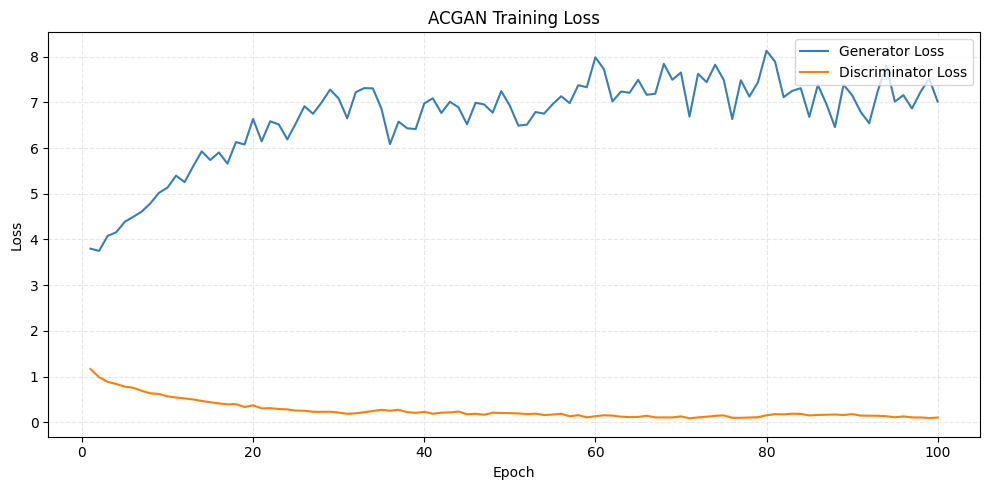

In [17]:
def plot_acgan_loss_graphs(G_losses, D_losses, num_epochs):
   
    # Split losses into epochs
    iterations_per_epoch = len(G_losses) // num_epochs
    G_losses_epoch = [
        np.mean(G_losses[i * iterations_per_epoch:(i + 1) * iterations_per_epoch])
        for i in range(num_epochs)
    ]
    D_losses_epoch = [
        np.mean(D_losses[i * iterations_per_epoch:(i + 1) * iterations_per_epoch])
        for i in range(num_epochs)
    ]

    # Plot epoch-aggregated losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), G_losses_epoch, label="Generator Loss", color="#377eb8")  # Blue
    plt.plot(range(1, num_epochs + 1), D_losses_epoch, label="Discriminator Loss", color="#ff7f00")  # Orange
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("ACGAN Training Loss")
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()

# Example Usage
plot_acgan_loss_graphs(G_losses, D_losses, num_epochs=100)


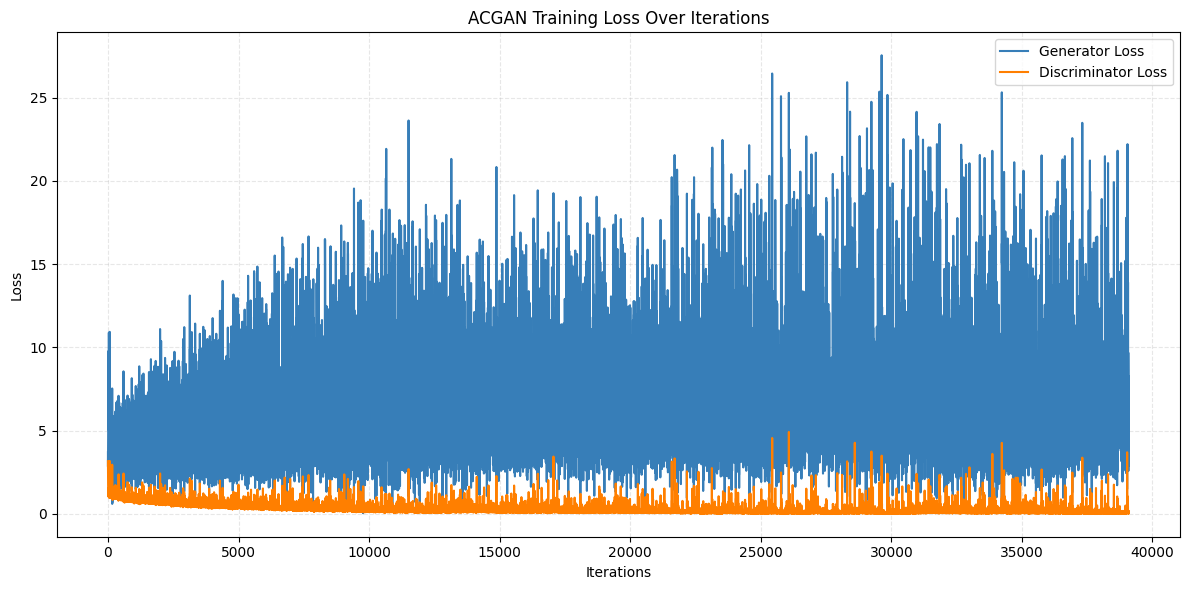

In [18]:
def plot_acgan_iterative_loss_graphs(G_losses, D_losses):
    """
    Plots generator and discriminator loss during training for every iteration.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(G_losses, label="Generator Loss", color="#377eb8")  # Blue
    plt.plot(D_losses, label="Discriminator Loss", color="#ff7f00")  # Orange
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("ACGAN Training Loss Over Iterations")
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()

# Example Usage
plot_acgan_iterative_loss_graphs(G_losses, D_losses)


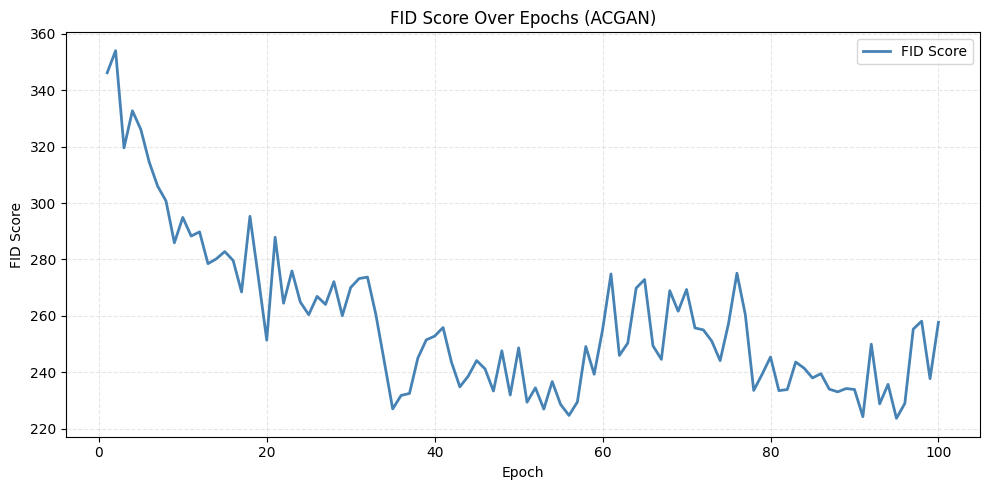

In [19]:
def plot_acgan_fid_scores(FID_scores, num_epochs):
    
    # Plot FID scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), FID_scores, label="FID Score", color="steelblue", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("FID Score")
    plt.title("FID Score Over Epochs (ACGAN)")
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()

# Example Usage
plot_acgan_fid_scores(FID_scores, num_epochs=100)


In [24]:
batch_size = 1000  # Adjust as needed
labels = torch.randint(0, num_classes, (batch_size,), device=device)
print("Labels: ", labels[:10])  # Print first 10 labels to verify diversity


Labels:  tensor([1, 8, 1, 7, 6, 9, 0, 1, 5, 0], device='cuda:0')


In [25]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
print("Noise Shape: ", noise.shape)  # Ensure it's [batch_size, nz, 1, 1]


Noise Shape:  torch.Size([1000, 100, 1, 1])


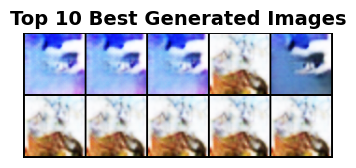

In [37]:
def display_best_fake_images_acgan(generator, discriminator, nz, num_classes, device, num_best=10, batch_size=1000):
    """
    Displays the top `num_best` fake images in a 2x5 grid for ACGAN.

    Args:
    - generator: Trained generator model.
    - discriminator: Trained discriminator model.
    - nz: Size of the latent noise vector.
    - num_classes: Number of image classes.
    - device: Device to use (CPU or GPU).
    - num_best: Number of best fake images to display (default: 10).
    - batch_size: Number of images generated for evaluation.

    Returns:
    - None
    """
    # Generate fake images using the generator
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    labels = torch.randint(0, num_classes, (batch_size,), device=device)
    with torch.no_grad():
        fake_images = generator(noise, labels).detach().cpu()  # Fake images on CPU
        fake_images_gpu = generator(noise, labels).detach()  # Fake images on GPU for scoring

    # Get discriminator scores for the generated fake images
    with torch.no_grad():
        scores, _ = discriminator(fake_images_gpu)  # Get real/fake scores
        scores = scores.view(-1).detach().cpu().numpy()  # Move scores to CPU for sorting

    # Sort fake images by discriminator scores (highest scores first)
    sorted_indices = np.argsort(scores)[::-1][:num_best]  # Sort scores in descending order and get top `num_best`
    best_fake_images = torch.stack([fake_images[i] for i in sorted_indices])  # Use stack to avoid stride issues

    # Display the best fake images in a grid (2 rows, 5 columns)
    grid = torchvision.utils.make_grid(best_fake_images, nrow=5, padding=2, normalize=True)

    # Plot the grid
    plt.figure(figsize=(4, 4))  # Adjust figure size to make the grid look better
    plt.axis("off")
    plt.title(f"Top {num_best} Best Generated Images", fontsize=14, fontweight="bold")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

# Example usage
display_best_fake_images_acgan(
    generator=netG,
    discriminator=netD,
    nz=100,
    num_classes=10,
    device=device,
    num_best=10,
    batch_size=1000
)


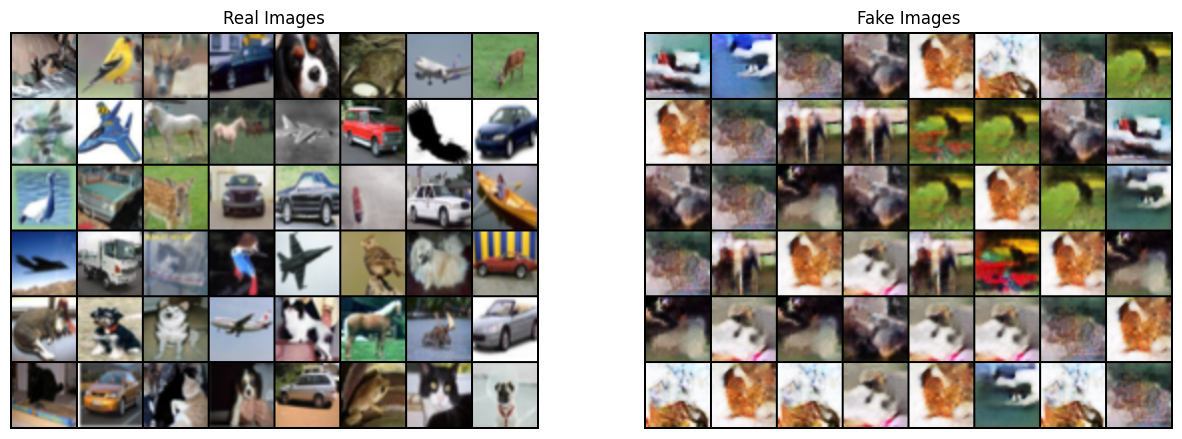

In [20]:
def display_real_and_fake_images_acgan(dataloader, generator, fixed_noise, fixed_labels, num_images=48):
    
    # Fetch real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_images] * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Generate fake images
    with torch.no_grad():
        fake_images = generator(fixed_noise[:num_images], fixed_labels[:num_images]).detach().cpu()
        fake_images = fake_images * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Create a figure for side-by-side display
    plt.figure(figsize=(15, 8))

    # Display real images on the left
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_images, nrow=8, padding=2, normalize=False), (1, 2, 0)))

    # Display fake images on the right
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(fake_images, nrow=8, padding=2, normalize=False), (1, 2, 0)))

    plt.show()

# Example Usage
fixed_noise = torch.randn(48, nz, 1, 1, device=device)
fixed_labels = torch.randint(0, num_classes, (48,), device=device)
display_real_and_fake_images_acgan(dataloader, netG, fixed_noise, fixed_labels, num_images=48)


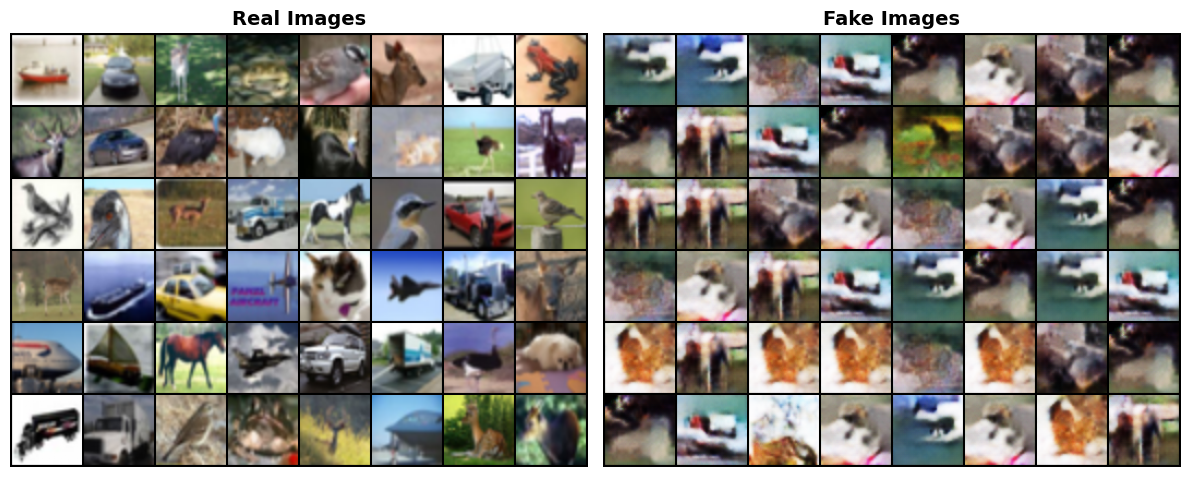

In [32]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_real_and_fake_images_acgan(dataloader, generator, nz, num_classes, device, num_images=48):
    """
    Displays real images on the left and fake images on the right in a grid.

    Args:
    - dataloader: DataLoader object to fetch real images.
    - generator: Trained generator model.
    - nz: Size of the latent noise vector.
    - num_classes: Number of classes in the dataset.
    - device: Device used for computation (e.g., 'cuda' or 'cpu').
    - num_images: Number of images to display per side.

    Returns:
    - None
    """
    # Fetch a batch of real images
    real_images, _ = next(iter(dataloader))  # Get a batch of real images
    real_images = real_images[:num_images] * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Generate a batch of fake images
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    labels = torch.randint(0, num_classes, (num_images,), device=device)
    with torch.no_grad():
        fake_images = generator(noise, labels).detach().cpu() * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Create the figure and display both sets of images
    plt.figure(figsize=(12, 6))

    # Display real images on the left
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images", fontsize=14, fontweight="bold")
    plt.imshow(np.transpose(vutils.make_grid(real_images, nrow=8, padding=2, normalize=False), (1, 2, 0)))

    # Display fake images on the right
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images", fontsize=14, fontweight="bold")
    plt.imshow(np.transpose(vutils.make_grid(fake_images, nrow=8, padding=2, normalize=False), (1, 2, 0)))

    plt.tight_layout()
    plt.show()

# Example Usage
display_real_and_fake_images_acgan(
    dataloader=dataloader, 
    generator=netG, 
    nz=100, 
    num_classes=10, 
    device=device, 
    num_images=48
)
